In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conways-reverse-game-of-life-2020/sample_submission.csv
/kaggle/input/conways-reverse-game-of-life-2020/train.csv
/kaggle/input/conways-reverse-game-of-life-2020/test.csv


In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train_df = pd.read_csv('/kaggle/input/conways-reverse-game-of-life-2020/train.csv')
test_df = pd.read_csv("/kaggle/input/conways-reverse-game-of-life-2020/test.csv")
sample_submission = pd.read_csv("/kaggle/input/conways-reverse-game-of-life-2020/sample_submission.csv")

In [4]:
start_features = [f for f in train_df.columns if "start" in f]
stop_features = [f for f in train_df.columns if "stop" in f]

features_in = stop_features + ["delta"]

In [5]:
from sklearn.model_selection import train_test_split
delta_train, delta_validation, stop_train, stop_validation, Y_train, Y_valid = train_test_split(train_df["delta"].values, 
                                                                                                train_df[stop_features].values.reshape(-1, 25, 25, 1).astype(float),
                                                                                                train_df[start_features].values.reshape(-1, 25, 25, 1).astype(float),
                                                                                                test_size=0.33,
                                                                                                )

In [6]:
X_train = [delta_train, stop_train]
X_valid = [delta_validation, stop_validation]
X_test = [test_df["delta"].values, test_df[stop_features].values.reshape(-1, 25, 25, 1).astype(float)]

X_all_train = [train_df["delta"].values, train_df[stop_features].values.reshape(-1, 25, 25, 1).astype(float)]
Y_all_train = train_df[start_features].values.reshape(-1, 25, 25, 1).astype(float)

In [7]:
def conv_block(inputs, filters, index, activation='relu'):
    """ Creates a convolutional block with batch normalization.
    
    Args:
        inputs: input layer.
        filters: number of filters in the convolutional layer.
        index: Index for the name of the convolutional layer.
        activation: Activation of the convolutional block. 
        (default='relu')
    
    Out:
        keras.layer: Layer of the convolutional block.
        
    """
    x = layers.Conv2D(filters, kernel_size=(3,3), padding="SAME", name=f'conv{index}')(inputs)
    x = layers.BatchNormalization()(x)
    return layers.Activation(activation, name=activation + str(index))(x)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
def create_model(dropout_prob=0.3):
    """ Creates the CNN model with the convolutional block.
    """
    input_delta = layers.Input(shape=(1,), name="input_delta")
    dense_delta = layers.Dense(25*25, name='dense_delta')(input_delta)
    dense_reshape = layers.Reshape((25,25,1), name='reshape_delta')(dense_delta)

    input_image = layers.Input(shape=(25,25,1), name="input_images")
    all_inputs = layers.Concatenate(axis=3, name='concatenate')([input_image, dense_reshape])

    x = conv_block(all_inputs, 32, index=1)    
    x = layers.Dropout(dropout_prob)(x)
    
    x = conv_block(x, 128, index=2)    
    x = layers.Dropout(dropout_prob)(x)
    
    x = conv_block(x, 256, index=3)
    x = layers.Dropout(dropout_prob)(x)
    
    x = conv_block(x, 64, index=4)
    x = layers.Dropout(dropout_prob)(x)
    
    out = conv_block(x, 1, index=5, activation='sigmoid')

    return Model(inputs=[input_delta, input_image], outputs=out)

In [9]:
model = create_model()
model.compile(loss="bce", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [10]:
history = model.fit(x=X_train,
                    y=Y_train, 
                    batch_size=128,
                    epochs=25,
                    validation_data=(X_valid, Y_valid))

Epoch 1/25


2023-06-08 05:38:47.437080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


262/262 [==============================] - 26s 54ms/step - loss: 0.6003 - accuracy: 0.7340 - val_loss: 0.4369 - val_accuracy: 0.8464
Epoch 2/25
262/262 [==============================] - 12s 44ms/step - loss: 0.5196 - accuracy: 0.7822 - val_loss: 0.4476 - val_accuracy: 0.8326
Epoch 3/25
262/262 [==============================] - 12s 44ms/step - loss: 0.4665 - accuracy: 0.8124 - val_loss: 0.4211 - val_accuracy: 0.8464
Epoch 4/25
262/262 [==============================] - 12s 44ms/step - loss: 0.4277 - accuracy: 0.8326 - val_loss: 0.3920 - val_accuracy: 0.8545
Epoch 5/25
262/262 [==============================] - 11s 44ms/step - loss: 0.3993 - accuracy: 0.8443 - val_loss: 0.3756 - val_accuracy: 0.8567
Epoch 6/25
262/262 [==============================] - 12s 44ms/step - loss: 0.3785 - accuracy: 0.8502 - val_loss: 0.3610 - val_accuracy: 0.8571
Epoch 7/25
262/262 [==============================] - 13s 49ms/step - loss: 0.3631 - accuracy: 0.8533 - val_loss: 0.3513 - val_accuracy: 0.8577
Epo

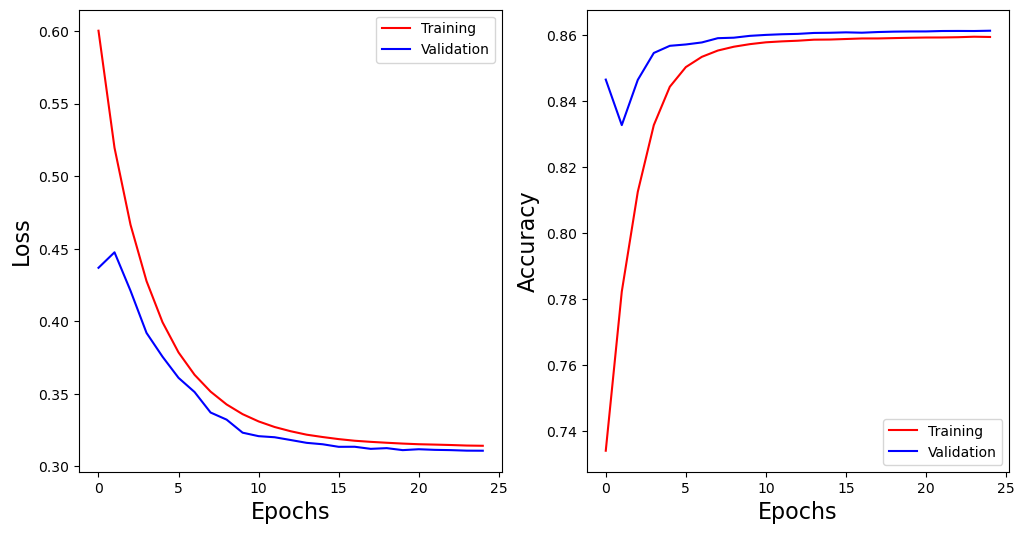

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

516/516 [==============================] - 2s 4ms/step


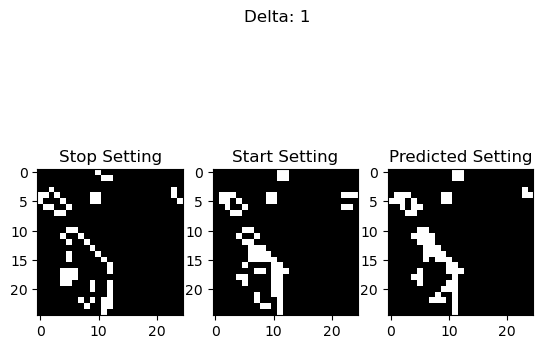

In [12]:
idx = 2

delta_sample = X_valid[0][idx]
img_sample = X_valid[1][idx]
out_sample = Y_valid[idx]
predicted = model.predict(X_valid)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Delta: " + str(delta_sample))

ax1.imshow((img_sample.reshape(25, 25)), cmap="gray")
ax1.set_title("Stop Setting")

ax2.imshow((out_sample.reshape(25, 25)), cmap="gray")
ax2.set_title("Start Setting")

ax3.imshow((predicted[idx]>=0.5).reshape(25, 25), cmap="gray")
ax3.set_title("Predicted Setting")
plt.show()

In [13]:
model = create_model()
model.compile(loss="bce", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [14]:
history = model.fit(x=X_all_train,
                    y=Y_all_train, 
                    batch_size=128,
                    epochs=20,
                   )

Epoch 1/20


2023-06-08 05:44:17.930997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


391/391 [==============================] - 20s 41ms/step - loss: 0.5797 - accuracy: 0.7462
Epoch 2/20
391/391 [==============================] - 15s 39ms/step - loss: 0.4805 - accuracy: 0.8033
Epoch 3/20
391/391 [==============================] - 15s 39ms/step - loss: 0.4216 - accuracy: 0.8344
Epoch 4/20
391/391 [==============================] - 15s 39ms/step - loss: 0.3845 - accuracy: 0.8480
Epoch 5/20
391/391 [==============================] - 15s 39ms/step - loss: 0.3609 - accuracy: 0.8535
Epoch 6/20
391/391 [==============================] - 15s 39ms/step - loss: 0.3455 - accuracy: 0.8558
Epoch 7/20
391/391 [==============================] - 15s 39ms/step - loss: 0.3354 - accuracy: 0.8570
Epoch 8/20
391/391 [==============================] - 15s 39ms/step - loss: 0.3287 - accuracy: 0.8577
Epoch 9/20
391/391 [==============================] - 15s 39ms/step - loss: 0.3242 - accuracy: 0.8580
Epoch 10/20
391/391 [==============================] - 15s 39ms/step - loss: 0.3212 - accurac

In [15]:
test_prediction = model.predict(X_test)
test_prediction = (test_prediction > 0.5).astype(int).reshape(test_df.shape[0], -1)
sub = test_df[["id"]].copy()
tmp = pd.DataFrame(test_prediction, columns=start_features)
submission = sub.join(tmp)

1563/1563 [==============================] - 6s 3ms/step


In [16]:
submission.to_csv("submission.csv", index=False)